In [1]:
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax, discreteProb
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from my_gym.envs.maze_mdp import MazeMDPEnv

import gym
import my_gym
from IPython.display import Video

from mazemdp import random_policy

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
  os.mkdir("./videos")

# Settings
NB_EPISODES = 50
TIMEOUT = 25
MAZE_SIZE = 10
MAZE_RATIO = 0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/my_gym to /tmp/pip-req-build-33lojpbc
  Running command git clone -q https://github.com/osigaud/my_gym /tmp/pip-req-build-33lojpbc
     |████████████████████████████████| 1.5 MB 9.7 MB/s 
     |████████████████████████████████| 1.3 MB 39.4 MB/s 
  Created wheel for bbrl-gym: filename=bbrl_gym-0.1.0-py3-none-any.whl size=17222 sha256=8abafaf52b96a6caf2d495924095f59d39cba10afd970a501d7609768e223bf9
  Stored in directory: /tmp/pip-ephem-wheel-cache-q072wasi/wheels/0b/2c/67/5df37c12451553731420023ff73d12effcae27a38cc5053550
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=9a7174cdf9bfb4c804787aa95edbbfb494160d3f1a71ef859499d2a12a73f53a
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for mazemdp: filename=mazemdp-0.1.1-py3-none-any.whl size=14721 sha2

In [2]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": MAZE_SIZE, "height": MAZE_SIZE, "ratio": MAZE_RATIO})
env.reset()
env.init_draw("The maze")

Output()

In [28]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

def actor_critic(
    mdp: MazeMDPEnv,
    nb_episodes:int,
    timeout:int,
    alpha_critic:float,
    alpha_actor:float,
    render:bool
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    v = np.zeros(mdp.nb_states)
    # policy = random_policy(mdp)

    cpt_it = 0

    q0 = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Actor-Critic")

    # for _ in tqdm(range(nb_episodes)):
    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)
        done = False
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw the max action from q table
            a = np.random.choice([
                i for i in range(len(q[s,:])) if q[s,i] == np.max(q[s,:])
            ])

            # Perform a step of the MDP
            y, r, done, _ = mdp.step(a)

            # Update critic
            delta = r + mdp.gamma * (v[y] - v[s])
            v[s] += alpha_critic * delta

            # Update actor
            q[s,a] += alpha_actor * delta
            # if q[s,a] > q[s,policy[s]]:
            #   policy[s] = a

            # Update the agent position
            s = y

            cpt_it += 1

        q_list.append(np.linalg.norm(np.maximum(q, q0)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Actor-Critic")
    return q, q_list, cpt_it

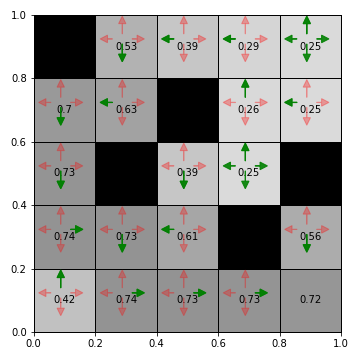

In [8]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": MAZE_RATIO})
env.reset()
# env.init_draw("The maze")

alpha_critic = 0.5
alpha_actor = 0.5
q, q_list, _ = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=True)

In [12]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": MAZE_RATIO})
env.reset()
# env.init_draw("The maze")

alpha_critic = 0.5
alpha_actor = 0.5
q, q_list, _ = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=False)

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": MAZE_RATIO})
env.reset()
# env.init_draw("The maze")

alpha_critic = 0.5
alpha_actor = 0.5
q, q_list, _ = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=True)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

# Studies on hyper-parameters

In [74]:
import time

# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": MAZE_RATIO})
env.reset()
# env.init_draw("The maze")

titles = ["Time study", "Iteration study"]

time_tab = []
cpt_it_tab = []
param_tab1 = []
param_tab2 = []

param_critic = np.arange(0.1, 0.5, 0.05)
param_actor = np.arange(0.1, 0.5, 0.05)

for alpha_critic in tqdm(param_critic):
  for alpha_actor in param_actor:
    start = time.time()
    q, q_list, cpt_it = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=False)
    time_tab.append(time.time() - start)
    cpt_it_tab.append(cpt_it)
    param_tab1.append(alpha_actor)
    param_tab2.append(alpha_critic)

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 0, 'N iteration')

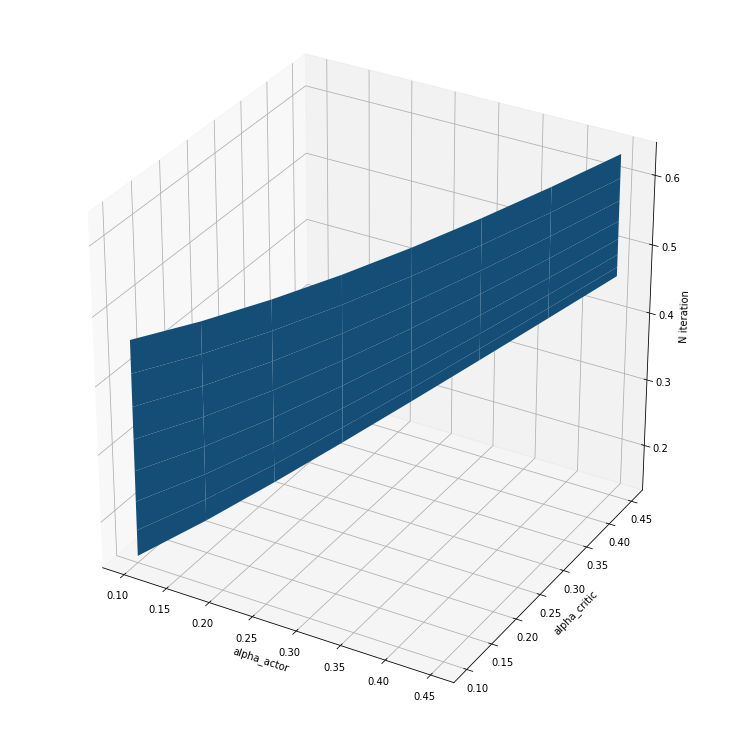

In [75]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

time_tab = np.array(time_tab)

X, Y = np.meshgrid(param_critic, param_actor)
R = np.sqrt(X**2 + Y**2)

ax.plot_surface(param_critic, param_actor, R)
ax.set_xlabel("alpha_actor")
ax.set_ylabel("alpha_critic")
ax.set_zlabel("N iteration")

Text(0.5, 0, 'N iteration')

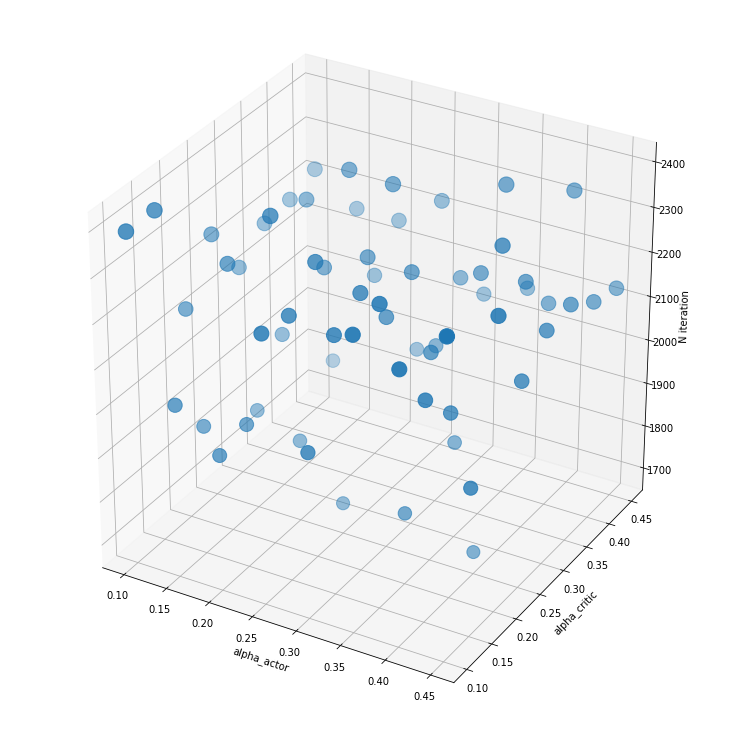

In [76]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(xs=param_tab1, ys=param_tab2, zs=cpt_it_tab, s=np.array(cpt_it_tab) / 10)
ax.set_xlabel("alpha_actor")
ax.set_ylabel("alpha_critic")
ax.set_zlabel("N iteration")

Text(0.5, 0, 'time to converge')

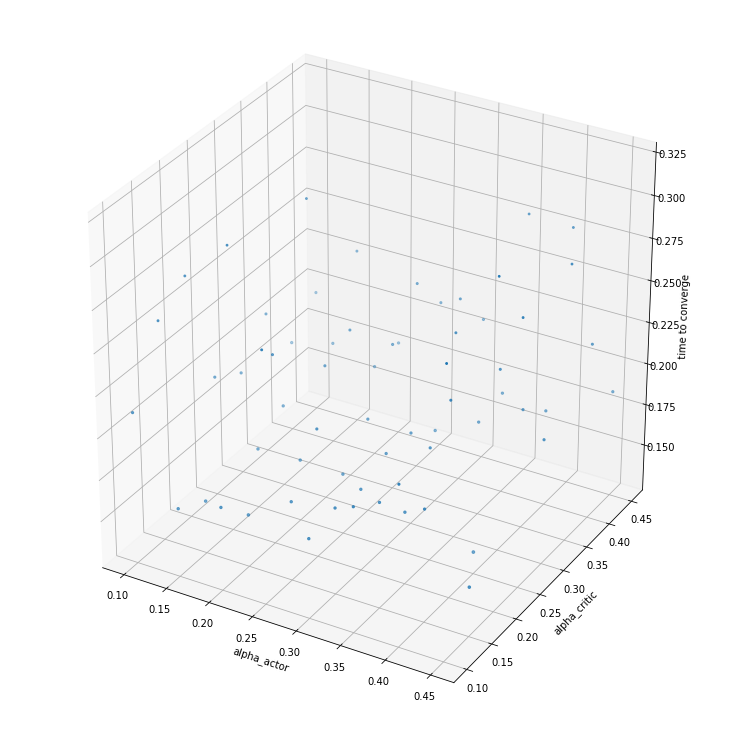

In [86]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(xs=param_tab1, ys=param_tab2, zs=time_tab, s=time_tab*500)
ax.set_xlabel("alpha_actor")
ax.set_ylabel("alpha_critic")
ax.set_zlabel("time to converge")